# Regresión Polinomial

Hasta ahora hemos utilizado modelos lineales para tareas de regresión y clasificación. Esto quiere decir que el resultado de nuestra predicción depende de una combinación lineal de los features. Sin embargo, hemos visto que es util preprocesar los features antes de alimentar un modelo. Un preprocesado muy util, que permite capturar relaciones no lineales entre los features, es el _preprocesado polinomico_. El resultado de componer este preprocesado con un modelo lineal de regresión es lo que se conoce como _regresión polinómica_, pero también puede ser utilizado para clasificación con un regresor logístico.

A lo largo de este notebook:
- Nos encontraremos con un conjunto de datos que posee características no lineales
- Entrenaremos un regresor logístico para clasificar
- Realizaremos un preprocesamiento polinómico de los datos, y veremos esto modifica nuestros datos.
- Entrenaremos un regresor logístico polinómico, y lo compararemos al regresor logístico lineal.
- Exploraremos distintos grados del polinomio, en búsqueda de encontrar _el grado óptimo_.




## Utils

A continuación le presentamos una función que podrá ser de utilidad para plotear regiones y fronteras de decisión. Si quiere puede analizar que hace, o simplemente usarla en sus soluciones.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

def plot_regions(classifier, x, t):
    """Plot results from classification."""
    plt.figure(figsize=(9, 7))

    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200),
                         np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evaluate decision function
    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # colour regions
    plt.pcolormesh(xx, yy, Z<0, cmap=plt.cm.bwr, shading='auto', alpha=0.4)
    # decision boundary
    plt.contour(xx, yy, 1/(1 + np.exp(-Z)), [0.05, 0.5, 0.95], colors=['0.5', 'k', '0.5'], zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    plt.plot(*xc1.T, 'ob', mfc='None', label='C1')
    plt.plot(*xc2.T, 'or', mfc='None', label='C2')

    # Remove ticks
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

    return

def plot_regions_ax(classifier, x, t, ax, grade):
    """Plot results from classification."""
    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200),
                         np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evaluate decision function
    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # colour regions
    ax.pcolormesh(xx, yy, Z<0, cmap=plt.cm.bwr, shading='auto', alpha=0.4)
    # decision boundary
    ax.contour(xx, yy, 1/(1 + np.exp(-Z)), [0.05, 0.5, 0.95], colors=['0.5', 'k', '0.5'], zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    ax.plot(*xc1.T, 'ob', mfc='None', label='C1')
    ax.plot(*xc2.T, 'or', mfc='None', label='C2')
    
    ax.set_title(f'Grade {grade}')

    # Remove ticks
    ax.axis('tight')

    return

## Dataset

La siguiente línea de código generará un dataset sintético a utilizar en este notebook:

In [2]:
import numpy as np
from sklearn.datasets import make_moons
X, y = make_moons(300, noise=0.25, random_state=42)

In [3]:
import pandas as pd
print(X.shape)
print(y.shape)

(300, 2)
(300,)


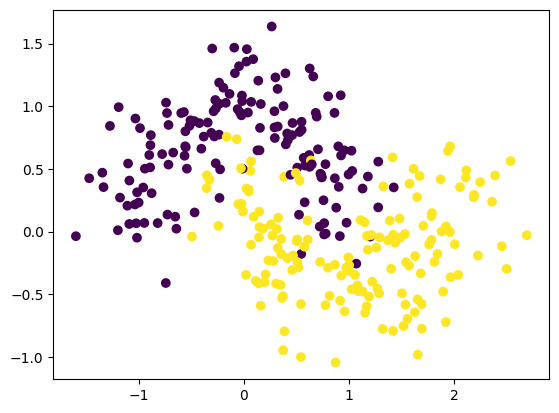

In [4]:
colors = ['r', 'b']
df = pd.DataFrame({
    'x1': X[:,0],
    'x2': X[:,1],
    'color': y
})
plt.scatter(x=df.x1, y=df.x2, c=df.color)
plt.show()

## Ejercicio 1

- Examine el dataset y grafíquelo
- Utilice la función `train_test_split` para separar un 20% del dataset como conjunto de test. Este servirá para evaluar la performance del modelo sobre datos no vistos anteriormente.
- Plotee conjuntos (train y test) para visualizar la separación.

In [5]:
from sklearn.model_selection import train_test_split

random_state = 40
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

In [6]:
print('X_train', X_train[:10])
print('X_test', X_test[:10])
print('y_train', y_train)
print('y_test', y_test)

X_train [[ 2.687953   -0.02892132]
 [ 0.73525921  0.45330264]
 [ 0.02500874  1.35609018]
 [ 1.69005923 -0.57999997]
 [ 0.15366383  0.82730814]
 [ 0.19702735 -0.40383262]
 [ 0.46263642  0.86641306]
 [-0.30871561  0.78757685]
 [ 1.17854057  0.43920467]
 [ 0.30632117 -0.41532768]]
X_test [[ 0.77774398 -0.01585511]
 [ 0.53045687  0.40791649]
 [ 0.92372267  0.60713957]
 [ 2.53325807  0.56283692]
 [ 1.25921959 -0.12811367]
 [ 0.800768    1.07926837]
 [ 1.50221432 -0.4925776 ]
 [ 0.51874564 -0.28666633]
 [-0.64043865  0.02290955]
 [ 0.32149225 -0.13055976]]
y_train [1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1
 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0]
y_test [

## Ejercicio 2

- Entrene un regresor logístico a los datos de entrenamiento. 
- Grafique la frontera de decisión (tip: puede utilizar la función utilitaria provista al comienzo del notebook)
- Mida la exactitud sobre el conjunto de entrenamiento.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(penalty=None).fit(X, y)
clf

LogisticRegression(penalty=None)

In [8]:
y_pred = clf.predict(X_train)

score = accuracy_score(y_train, y_pred)
score

0.861904761904762

## Ejercicio 3

Un polinomio de grado $M$ es una combinación lineal de monomios de grado $0$ hasta $M$. Es decir, si miramos un polinomio univariable de segundo grado, este es de la forma:
$$w_0 + w_1 x + w_2 x^2 $$
que no es mas que una combinacion lineal de los monomios $x^0$ ($=1$), $x^1$ ($=x$) y $x^2$.

El caso de dos variables $x_1$ y $x_2$ (como nuestro dataset), tambien hay que tener en cuenta los terminos cruzados:
$$w_{(0,0)} + w_{(1,0)} x_1 + w_{(0,1)} x_2 + w_{(2,0)} x_1^2 + w_{(1,1)} x_1 x_2 + w_{(0,2)} x_2^2$$

es decir una combinacion lineal de los monomios $1$, $x_1$, $x_2$, $x_1^2$, $x_2^2$ y $x_1 x_2$.

Esto implica que un modelo polinomico no es mas que un modelo lineal, con un preprocesado que consiste en tomar los features del dataset, y devolver todos los monomios de estos hasta cierto grado. 

Este ya esta implementado en sklearn:



- Importe de `sklearn.preprocessing` el transformer `PolynomialFeatures`. Analice su firma. (_Pista: `?`_)
- Instancielo con el grado polinomico 1, 2 y 3. Para cada uno de ellos, transforme los datos (_Pista: `.fit_transform()`_), y examine como cambia el dataset, en particular mire el `shape`.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly_g1 = PolynomialFeatures(1)
pg1 = poly_g1.fit_transform(X_train)
print(pg1.shape)

poly_g2 = PolynomialFeatures(2)
pg2 = poly_g2.fit_transform(X_train)
print(pg2.shape)

poly_g3 = PolynomialFeatures(3)
pg3 = poly_g3.fit_transform(X_train)
print(pg3.shape)

(210, 3)
(210, 6)
(210, 10)


## Ejercicio 4

- Entrene un regresor logístico polinómico de grado 3 sobre el dataset de entrenamiento.
- Evalúe su exactitud sobre el conjuntos de entrenamiento. Compare con el obtenido en el ejercicio 2.

Para plotear la frontera de decisión, proponemos que sigas los siguientes pasos:
- Arme un pipeline de sklearn usando como primer paso el preprocesador polinomico, y como ultimo el regresor lineal. (_Pista: tanto `Pipeline` como `make_pipeline` de `sklearn.pipeline` pueden servir_)
- Entrene este pipeline sobre el conjunto de entrenamiento
- Pase el pipeline entrenado al argumento `classifier` de la función de `plot_regions` provista al comienzo del notebook.

_Opcional:_
- Examine como cambia el resultado incluyendo un `StandardScaler` entre el preprocesado polinomico y el regresor logístico. ¿Que cree que ocurre en este paso?

In [19]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_g3 = Pipeline([
    ('polynomial', PolynomialFeatures(3)),
    ('logistic', LogisticRegression(penalty=None))
])
pipe_g3.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('logistic', LogisticRegression(penalty=None))])

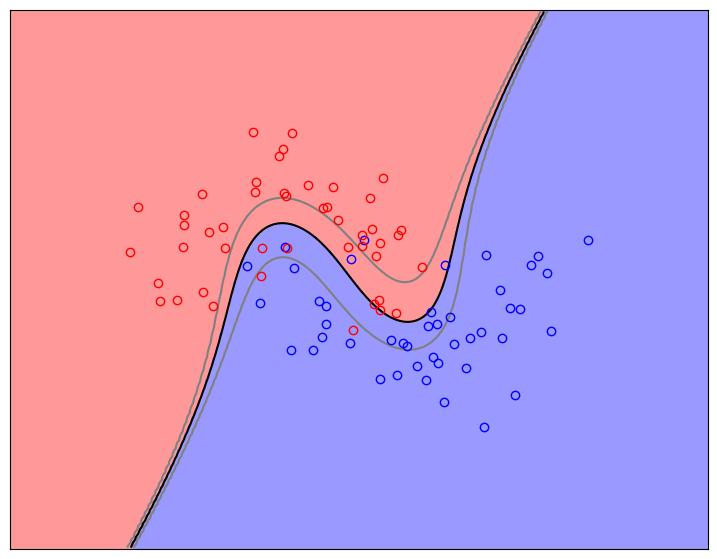

In [20]:
plot_regions(classifier=pipe_g3, x=X_test, t=y_test)

In [21]:
y_pred_pipe_g3 = pipe_g3.predict(X_train)
accuracy_score(y_train, y_pred_pipe_g3)

0.9285714285714286

In [24]:
pipe_g3_opc = Pipeline([
    ('polynomial', PolynomialFeatures(3)),
    ('std_scaler', StandardScaler()),
    ('logistic', LogisticRegression(penalty=None)),
])
pipe_g3_opc.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('std_scaler', StandardScaler()),
                ('logistic', LogisticRegression(penalty=None))])

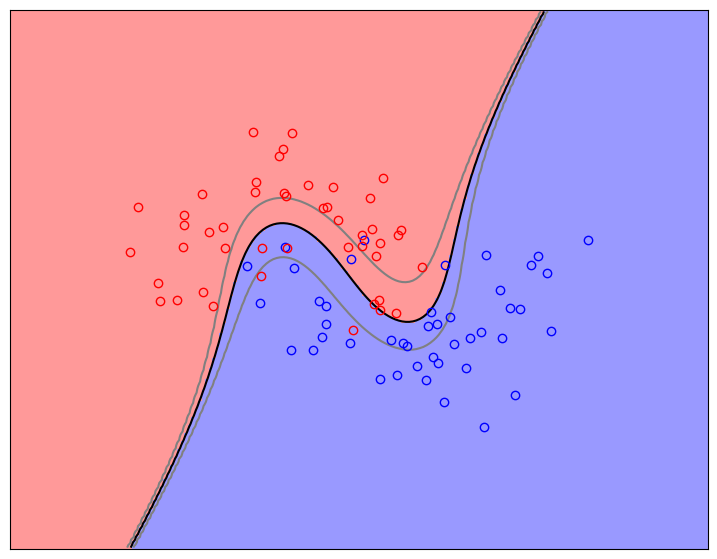

In [25]:
plot_regions(classifier=pipe_g3_opc, x=X_test, t=y_test)

In [26]:
y_pred_pipe_g3_opc = pipe_g3_opc.predict(X_train)
accuracy_score(y_train, y_pred_pipe_g3)

0.9285714285714286

## Ejercicio 5

- Repita el ejercicio anterior para varios valores del grado polinómico (entre 1 y 10)
- Compare cualitativamente como cambian las fronteras de decisión. 
- Compare que pasa con la exactitud sobre el conjunto de entrenamiento.
- ¿Que cree que pasará con estos modelos cuando sean evaluados sobre datos que no han visto anteriormente?
- Compare que pasa con la exactitud sobre el conjunto de **evaluación**.
- ¿Que conclusiones extrae de esto?

-_Opcional_: Registre los valores de exactitud en ambos conjuntos (train y test), y ploteelas en función del grado polinómico usado. ¿Que observa?

In [51]:
import warnings
warnings.filterwarnings('ignore')

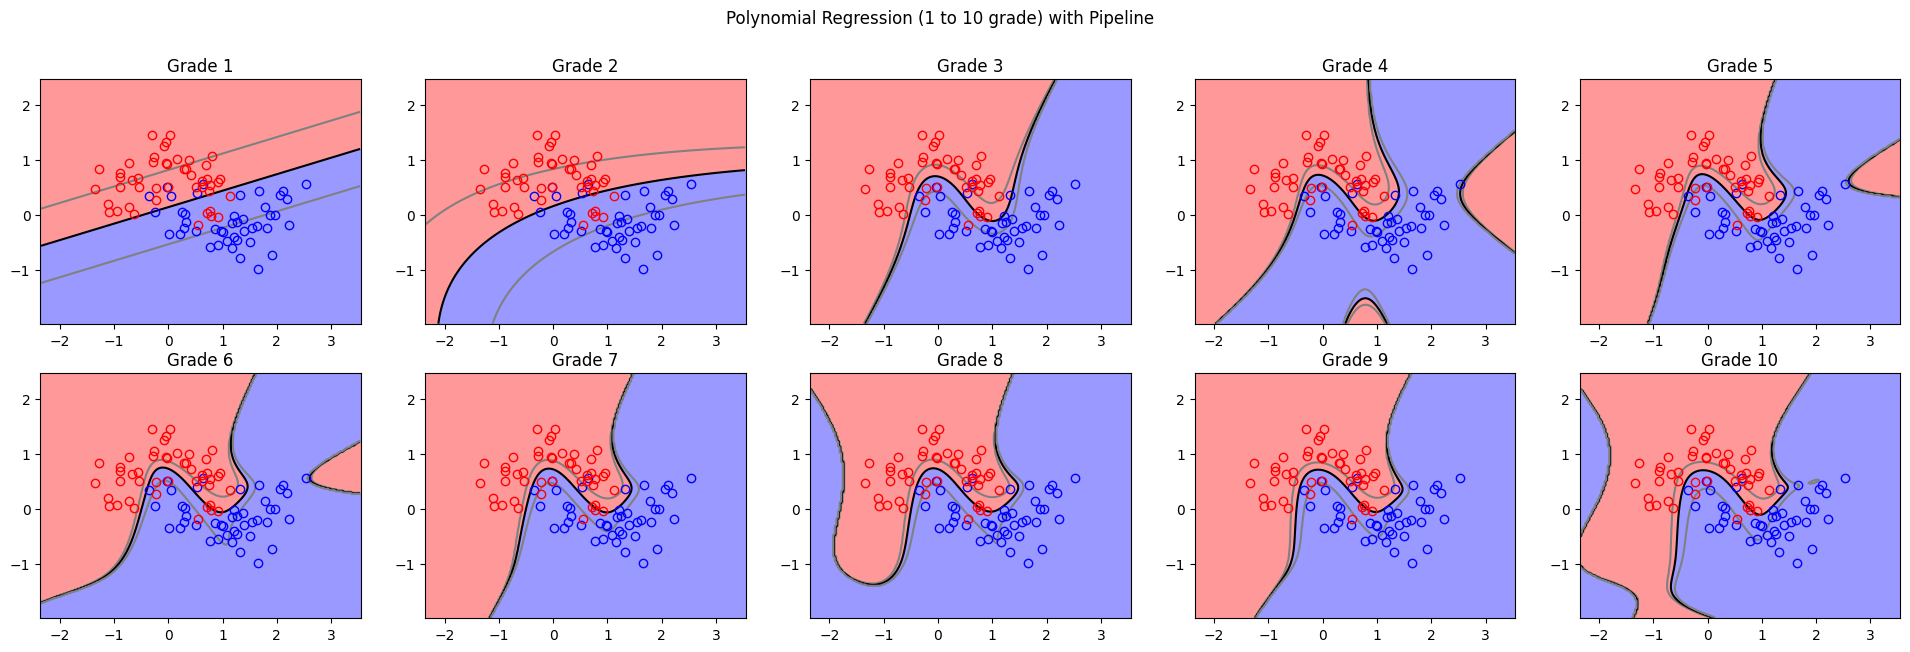

In [66]:
fig, axs = plt.subplots(2, 5, figsize=(24, 7))
fig.suptitle('Polynomial Regression (1 to 10 grade) with Pipeline')
acc_strs = []
accs = []
for grade in range(0, 10):
    pipe = Pipeline([
    ('polynomial', PolynomialFeatures(grade + 1)),
    ('logistic', LogisticRegression(penalty=None))
    ])
    pipe.fit(X_train, y_train)
    ax_x1 = grade if grade < 5 else grade - 5
    ax_x2 = 0 if grade < 5 else 1
    plot_regions_ax(classifier=pipe, x=X_test, t=y_test, ax=axs[ax_x2, ax_x1], grade=grade+1)
    y_pred_pipe_train = pipe.predict(X_train)
    y_pred_pipe_test = pipe.predict(X_test)
    acc = [accuracy_score(y_train, y_pred_pipe_train), accuracy_score(y_test, y_pred_pipe_test)]
    accs.append(acc)
    acc_strs.append(f'Grade {grade + 1} - Accuracy (train) {acc[0]} - Accuracy (test) {acc[1]}')
plt.show();

In [65]:
for fstr in acc_strs:
    print(fstr)

Grade 1 - Accuracy (train) 0.8714285714285714 - Accuracy (test) 0.8777777777777778
Grade 2 - Accuracy (train) 0.8571428571428571 - Accuracy (test) 0.8777777777777778
Grade 3 - Accuracy (train) 0.9285714285714286 - Accuracy (test) 0.9222222222222223
Grade 4 - Accuracy (train) 0.9428571428571428 - Accuracy (test) 0.9222222222222223
Grade 5 - Accuracy (train) 0.9523809523809523 - Accuracy (test) 0.9111111111111111
Grade 6 - Accuracy (train) 0.9476190476190476 - Accuracy (test) 0.9
Grade 7 - Accuracy (train) 0.9428571428571428 - Accuracy (test) 0.9
Grade 8 - Accuracy (train) 0.9476190476190476 - Accuracy (test) 0.9
Grade 9 - Accuracy (train) 0.9428571428571428 - Accuracy (test) 0.9
Grade 10 - Accuracy (train) 0.9428571428571428 - Accuracy (test) 0.9


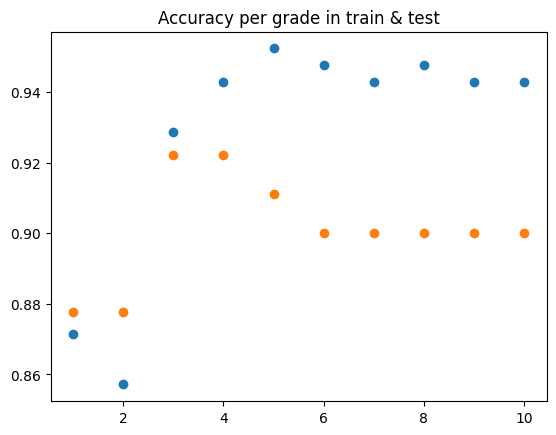

In [73]:
scores = np.asarray(accs)
plt.scatter(x=list(range(1, len(accs) + 1)), y=scores[:,0])
plt.scatter(x=list(range(1, len(accs) + 1)), y=scores[:,1])
plt.title('Accuracy per grade in train & test');

## Ejercicio 6

- En función a lo observado, defina un método para elegir el _*grado polinómico óptimo*_. 
- Encuentre, segun este criterio, cual es el grado óptimo para este conjunto de datos.

In [12]:
# Tu turno


## Formulario de asistencia

Por favor, no olviden completar el siguiente formulario antes del miércoles 09/04 a la 23:59.

[link a definir]